# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [1]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [2]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.1 MB/s eta 0:00:00


In [2]:
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

c:\Users\Andy\DL_ass2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## For colab
# from google.colab import drive
# drive.mount('/content/drive')
dataset_dir = "ass2_data"

In [4]:
pos_data_path = os.path.join(dataset_dir, "pos_data.pkl")
type_data_path = os.path.join(dataset_dir, "type_data.pkl")
smiles_data_path = os.path.join(dataset_dir, "smiles.pkl")
data_split_path = os.path.join(dataset_dir, "data_split.npz")
formation_energy_path = os.path.join(dataset_dir, "formation_energy.npz")
with open(pos_data_path, 'rb') as f:
    pos_data = pickle.load(f)

with open(type_data_path, 'rb') as f:
    type_data = pickle.load(f)

with open(smiles_data_path, 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load(data_split_path)

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

train_idxes, val_idxes = train_test_split(
    train_idxes, test_size=0.1, random_state=42
)
formation_energy = np.load(formation_energy_path)

fe = formation_energy['y'] # normalized formation energy
fe_tensor = torch.tensor(fe, dtype=torch.float32) # Convert to tensor
mu = formation_energy['mu']
std = formation_energy['sigma']
print("Target tensor shape:", fe_tensor.shape)
print(f"Train size: {len(train_idxes)} | Val size: {len(val_idxes)} | Test size: {len(test_idxes)}")
print("Example target (train):", fe_tensor[train_idxes[0]])

Target tensor shape: torch.Size([129012])
Train size: 107110 | Val size: 11902 | Test size: 10000
Example target (train): tensor(-0.4042)


In [5]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 107110, test: 10000, sum: 117110


In [6]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


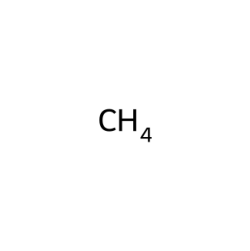

In [7]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  N  │  7   │    -0.164│    -1.059│    -0.436
  C  │  6   │    -0.070│     0.054│    -0.140
  C  │  6   │     0.072│     1.463│     0.238
  C  │  6   │     1.495│     1.950│     0.133
  C  │  6   │     2.672│     1.589│     1.036
  C  │  6   │     3.395│     2.805│     0.393
  C  │  6   │     3.602│     2.375│    -1.087
  C  │  6   │     2.082│     2.439│    -1.203
  C  │  6   │     1.974│     3.375│    -0.019
  H  │  1   │    -0.583│     2.062│    -0.407
  H  │  1   │    -0.305│     1.583│     1.262
  H  │  1   │     2.430│     1.771│     2.088
  H  │  1   │     3.141│     0.604│     0.929
  H  │  1   │     4.168│     3.343│     0.936
  H  │  1   │     4.075│     3.166│    -1.676
  H  │  1   │     4.111│     1.422│    -1.270
  H  │  1   │     1.475│     2.434│    -2.100
  H  │  1   │     1.476│     4.324│     0.115


SMILE: N#CC[C@@]12C[C@H]3C[C@@H]1[C@H]32


Formation Energy: -79.409
Formation

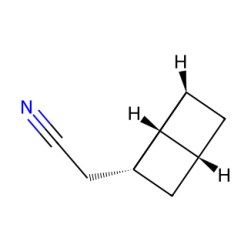

In [8]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [14]:
# Task 1, Tokenize character by character

all_chars = [char for smile in smiles_data for char in smile] # Flattens chars
vocab = sorted(set(all_chars))
vocab = ['<PAD>', '<UNK>'] + vocab
token_to_idx = {token: idx for idx, token in enumerate(vocab)}

def smiles_to_sequence(smile):
    return [token_to_idx.get(char, token_to_idx['<UNK>']) for char in smile]

tokenized = [smiles_to_sequence(s) for s in smiles_data]
max_len = max(len(seq) for seq in tokenized)
padded = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq) for seq in tokenized],
    batch_first=True,
    padding_value=token_to_idx['<PAD>']
)
print(f"Vocab size: {len(vocab)}")
print(f"Max SMILES length: {max_len}")
print("Example (index 0):", padded[0])

Vocab size: 26
Max SMILES length: 62
Example (index 0): tensor([15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0])


In [15]:
class SmilesDataset(Dataset):
  def __init__(self, smiles_tensor, energy_tensor, indicies):
    self.smiles_tensor = smiles_tensor[indicies]
    self.energy_tensor = energy_tensor[indicies]

  def __len__(self):
    return len(self.energy_tensor)

  def __getitem__(self, idx):
      return self.smiles_tensor[idx], self.energy_tensor[idx]

train_dataset = SmilesDataset(padded, fe_tensor, train_idxes)
val_dataset   = SmilesDataset(padded, fe_tensor, val_idxes)
test_dataset  = SmilesDataset(padded, fe_tensor, test_idxes)

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS)
test_loader = DataLoader(test_dataset, batch_size=BS)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 837
Validation batches: 93
Test batches: 79


In [20]:
class SMILESEnergyPredictor(nn.Module):
  def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=token_to_idx['<PAD>'])
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 1)
  def forward(self, x):
    emb = self.embedding(x)
    output, (h_n, _) = self.lstm(emb)
    out = self.fc(h_n.squeeze(0))
    return out.squeeze(1)



In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=10):
  best_val_loss = float('inf')
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in train_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      preds = model(x_batch)
      loss = criterion(preds, y_batch)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * x_batch.size(0)
      pbar.set_postfix(train_loss=loss.item())
    train_loss /= len(train_loader.dataset)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth")
    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")





In [31]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 1.0031 | Val Loss: 1.0110


Epoch 2/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 0.4145 | Val Loss: 0.0103


Epoch 3/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 0.0078 | Val Loss: 0.0076


Epoch 4/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 0.0051 | Val Loss: 0.0043


Epoch 5/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 0.0046 | Val Loss: 0.0076


Epoch 6/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 0.0042 | Val Loss: 0.0032


Epoch 7/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 0.0036 | Val Loss: 0.0039


Epoch 8/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 0.0034 | Val Loss: 0.0052


Epoch 9/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 0.0033 | Val Loss: 0.0035


Epoch 10/10:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0030 | Val Loss: 0.0041


In [32]:
# model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth"))
model.eval()

# 2) Prepare loss functions
mse_loss = nn.MSELoss(reduction="mean")
mae_loss = nn.L1Loss(reduction="mean")

# 3) Loop over test set
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)

        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

# 4) Concatenate
preds = torch.cat(all_preds)    # shape [N]
targets = torch.cat(all_targets)

# 5) Metrics in normalized space
mse_norm = mse_loss(preds, targets).item()
mae_norm = mae_loss(preds, targets).item()

print(f"Test (normalized) →  MSE: {mse_norm:.5f} | MAE: {mae_norm:.5f}")

# 6) Denormalize to actual formation energies
preds_actual   = preds * std + mu
targets_actual = targets * std + mu

mse_actual = mse_loss(preds_actual, targets_actual).item()
mae_actual = mae_loss(preds_actual, targets_actual).item()

print(f"Test (actual)     →  MSE: {mse_actual:.5f} | MAE: {mae_actual:.5f}")

Test (normalized) →  MSE: 0.00388 | MAE: 0.04801
Test (actual)     →  MSE: 0.41279 | MAE: 0.49505


<ipython-input-32-9c569b538981>:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_actual   = preds * std + mu
<ipython-input-32-9c569b538981>:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  targets_actual = targets * std + mu


In [ ]:
# geometric

In [37]:

from torch_geometric.data import Data, DataLoader as GeometricDataLoader
from torch_geometric.nn import SchNet
from torch.optim.lr_scheduler import ReduceLROnPlateau 

def create_molecular_graph(positions, atom_types, cutoff=5.0):
    """
    Create molecular graph for SchNet (uses z for atomic numbers and pos for positions).
    """
    positions = np.array(positions, dtype=np.float32)
    atom_types = np.array(atom_types, dtype=np.int64)
    
    # Convert to tensors
    pos = torch.tensor(positions, dtype=torch.float32)
    z = torch.tensor(atom_types, dtype=torch.long)  # SchNet uses 'z' for atomic numbers
    
    # SchNet handles edge creation internally based on cutoff distance
    data = Data(z=z, pos=pos)
    
    return data


In [38]:
class GeometricDataset(Dataset):
    """Dataset for geometric molecular data"""
    
    def __init__(self, pos_data, type_data, energy_tensor, indices, cutoff=5.0):
        self.pos_data = [pos_data[i] for i in indices]
        self.type_data = [type_data[i] for i in indices]
        self.energy_tensor = energy_tensor[indices]
        self.cutoff = cutoff
    
    def __len__(self):
        return len(self.energy_tensor)
    
    def __getitem__(self, idx):
        # Create molecular graph
        graph = create_molecular_graph(
            self.pos_data[idx], 
            self.type_data[idx], 
        )
        graph.y = self.energy_tensor[idx]
        return graph

# Create geometric datasets
geo_train_dataset = GeometricDataset(pos_data, type_data, fe_tensor, train_idxes)
geo_val_dataset = GeometricDataset(pos_data, type_data, fe_tensor, val_idxes)
geo_test_dataset = GeometricDataset(pos_data, type_data, fe_tensor, test_idxes)

# Create data loaders
geo_batch_size = 32  # Smaller batch size for graphs
geo_train_loader = GeometricDataLoader(geo_train_dataset, batch_size=geo_batch_size, shuffle=True)
geo_val_loader = GeometricDataLoader(geo_val_dataset, batch_size=geo_batch_size)
geo_test_loader = GeometricDataLoader(geo_test_dataset, batch_size=geo_batch_size)


c:\Users\Andy\DL_ass2\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [41]:
class GeometricEnergyPredictor(nn.Module):
    """
    Simple SchNet implementation for formation energy prediction.
    SchNet is specifically designed for molecular property prediction from 3D coordinates.
    """
    
    def __init__(self, hidden_channels=128, num_filters=128, num_interactions=6, 
                 num_gaussians=50, cutoff=5.0):
        super().__init__()
        
        self.schnet = SchNet(
            hidden_channels=hidden_channels,
            num_filters=num_filters,
            num_interactions=num_interactions,
            num_gaussians=num_gaussians,
            cutoff=cutoff,
            readout='mean'  # Global mean pooling
        )
        
    def forward(self, data):
        return self.schnet(data.z, data.pos, data.batch).squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

geo_model = GeometricEnergyPredictor(
    hidden_channels=128,
    num_filters=128,
    num_interactions=6,
    num_gaussians=50,
    cutoff=5.0  # 10 Angstrom cutoff
).to(device)


In [42]:
def train_geometric_model(model, train_loader, val_loader, epochs=15, lr=1e-3):
    """Train the geometric model for formation energy prediction"""
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        num_batches = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            preds = model(batch)
            loss = criterion(preds, batch.y)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
            pbar.set_postfix(train_loss=loss.item())
        
        train_loss /= num_batches
        
        # Validation
        model.eval()
        val_loss = 0
        num_val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch)
                loss = criterion(preds, batch.y)
                val_loss += loss.item()
                num_val_batches += 1
        
        val_loss /= num_val_batches
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "models/geometric_model.pth")
        
        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    print(f"Best validation loss: {best_val_loss:.6f}")

# Train the geometric model
print("Training geometric model...")
train_geometric_model(geo_model, geo_train_loader, geo_val_loader, epochs=15, lr=1e-3)

Training geometric model...


Epoch  1 | Train Loss: 0.056429 | Val Loss: 0.013421 | LR: 0.001000


Epoch  2 | Train Loss: 0.012619 | Val Loss: 0.008684 | LR: 0.001000


Epoch  3 | Train Loss: 0.007135 | Val Loss: 0.027174 | LR: 0.001000


Epoch  4 | Train Loss: 0.006573 | Val Loss: 0.033419 | LR: 0.001000


Epoch  5 | Train Loss: 0.004607 | Val Loss: 0.009894 | LR: 0.001000


Epoch  6 | Train Loss: 0.003787 | Val Loss: 0.002163 | LR: 0.001000


Epoch  7 | Train Loss: 0.003812 | Val Loss: 0.002266 | LR: 0.001000


Epoch  8 | Train Loss: 0.003288 | Val Loss: 0.007521 | LR: 0.001000


Epoch  9 | Train Loss: 0.003071 | Val Loss: 0.007656 | LR: 0.001000


Epoch 10 | Train Loss: 0.002766 | Val Loss: 0.001506 | LR: 0.001000


Epoch 11 | Train Loss: 0.002940 | Val Loss: 0.001847 | LR: 0.001000


Epoch 12 | Train Loss: 0.002764 | Val Loss: 0.001683 | LR: 0.001000


Epoch 13 | Train Loss: 0.003044 | Val Loss: 0.002654 | LR: 0.001000


Epoch 14 | Train Loss: 0.002348 | Val Loss: 0.002315 | LR: 0.001000


Epoch 15 | Train Loss: 0.002441 | Val Loss: 0.001452 | LR: 0.001000
Best validation loss: 0.001452


In [43]:
# Evaluate the geometric model
print("Evaluating geometric model on test set...")

# Load the best model
geo_model.load_state_dict(torch.load("models/geometric_model.pth"))
geo_model.eval()

# Loss functions
mse_loss = nn.MSELoss(reduction="mean")
mae_loss = nn.L1Loss(reduction="mean")

# Collect predictions
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in tqdm(geo_test_loader, desc="Evaluating"):
        batch = batch.to(device)
        preds = geo_model(batch)
        
        all_preds.append(preds.cpu())
        all_targets.append(batch.y.cpu())

# Concatenate all predictions and targets
preds = torch.cat(all_preds)
targets = torch.cat(all_targets)

# Metrics in normalized space
mse_norm = mse_loss(preds, targets).item()
mae_norm = mae_loss(preds, targets).item()

print(f"Geometric Model Test Results (normalized) →  MSE: {mse_norm:.5f} | MAE: {mae_norm:.5f}")

# Denormalize to actual formation energies
preds_actual = preds * std + mu
targets_actual = targets * std + mu

mse_actual = mse_loss(preds_actual, targets_actual).item()
mae_actual = mae_loss(preds_actual, targets_actual).item()

print(f"Geometric Model Test Results (actual)     →  MSE: {mse_actual:.5f} | MAE: {mae_actual:.5f}")

# Compare with SMILES model results
print("\nModel Comparison:")
print("SMILES Model   (actual)     →  MSE: 0.41279 | MAE: 0.49505")
print(f"Geometric Model (actual)    →  MSE: {mse_actual:.5f} | MAE: {mae_actual:.5f}")

if mse_actual < 0.41279:
    print("Geometric model outperforms SMILES model!")
else:
    print("SMILES model still has lower error.")

Evaluating geometric model on test set...


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 217.80it/s]

Geometric Model Test Results (normalized) →  MSE: 0.00137 | MAE: 0.02500
Geometric Model Test Results (actual)     →  MSE: 0.14579 | MAE: 0.25775

Model Comparison:
SMILES Model   (actual)     →  MSE: 0.41279 | MAE: 0.49505
Geometric Model (actual)    →  MSE: 0.14579 | MAE: 0.25775
Geometric model outperforms SMILES model!



C:\Users\Andy\AppData\Local\Temp\ipykernel_9532\987267128.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_actual = preds * std + mu
C:\Users\Andy\AppData\Local\Temp\ipykernel_9532\987267128.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  targets_actual = targets * std + mu


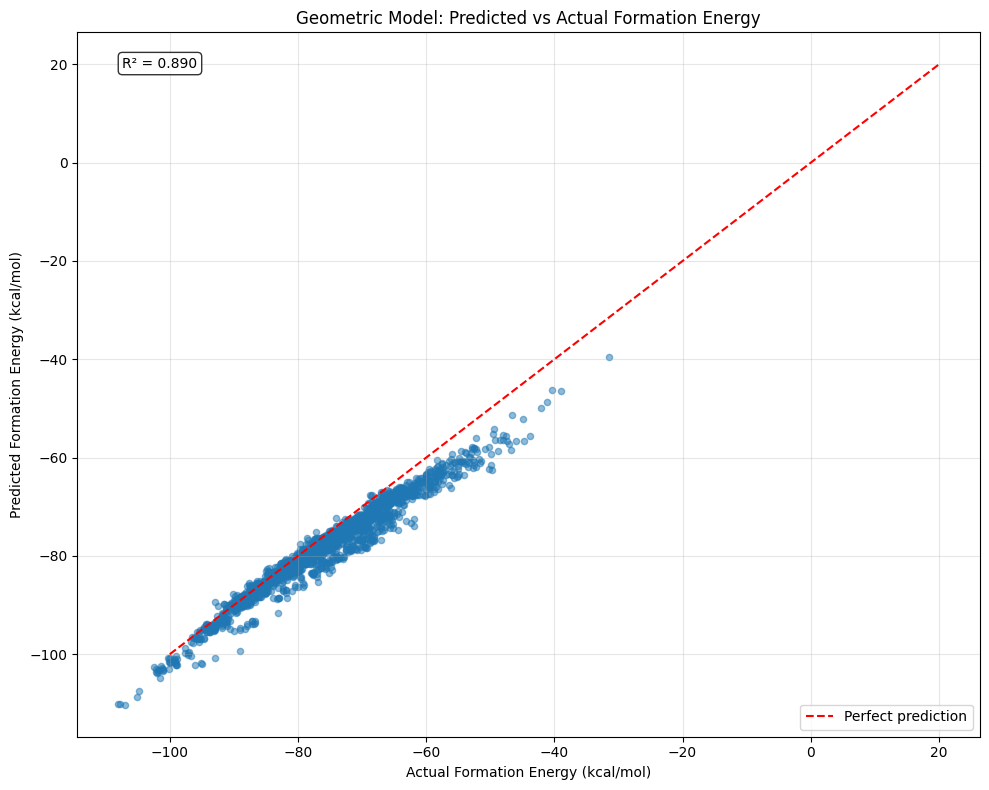

R² Score on test set: 0.8822


In [19]:
# Visualize some predictions vs actual values
import matplotlib.pyplot as plt

# Create a scatter plot comparing predictions vs actual values
plt.figure(figsize=(10, 8))

# Convert to numpy for plotting
preds_np = preds_actual.numpy()
targets_np = targets_actual.numpy()

# Sample for visualization (too many points)
n_sample = 2000
indices = np.random.choice(len(preds_np), n_sample, replace=False)
preds_sample = preds_np[indices]
targets_sample = targets_np[indices]

plt.scatter(targets_sample, preds_sample, alpha=0.5, s=20)
plt.plot([-100, 20], [-100, 20], 'r--', label='Perfect prediction')
plt.xlabel('Actual Formation Energy (kcal/mol)')
plt.ylabel('Predicted Formation Energy (kcal/mol)')
plt.title('Geometric Model: Predicted vs Actual Formation Energy')
plt.legend()
plt.grid(True, alpha=0.3)

# Add R² score
from sklearn.metrics import r2_score
r2 = r2_score(targets_sample, preds_sample)
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"R² Score on test set: {r2_score(targets_np, preds_np):.4f}")

## Task 2

## Task 3

In [1]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [2]:
canonicalize("COO"), canonicalize("O(C)O")

('None', 'None')

In [3]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")

(False, False, False)

**Objective**: Build a model that generates 5000 molecules

**LSTM**

In [53]:
# Utility functions for SMILES validation and processing
def is_valid_smiles(smiles):
    """Check if SMILES string is chemically valid using RDKit."""
    if smiles is None or len(smiles) == 0:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    """Convert SMILES to canonical form."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return None
    except:
        return None

def clean_smiles(smiles):
    """Clean generated SMILES string."""
    # Remove padding tokens and unknown tokens
    cleaned = smiles.replace('<PAD>', '').replace('<UNK>', '').replace('<END>', '')
    return cleaned.strip()

# Enhanced vocabulary for generation (including special tokens)
def create_generation_vocab():
    """Create vocabulary specifically for SMILES generation."""
    # Get all unique characters from training SMILES
    all_chars = set()
    for smile in smiles_data:
        all_chars.update(smile)
    
    # Add special tokens for generation
    special_tokens = ['<PAD>', '<START>', '<END>', '<UNK>']
    vocab = special_tokens + sorted(list(all_chars))
    
    char_to_idx = {char: idx for idx, char in enumerate(vocab)}
    idx_to_char = {idx: char for idx, char in enumerate(vocab)}
    
    return vocab, char_to_idx, idx_to_char

# Create generation vocabulary
gen_vocab, char_to_idx, idx_to_char = create_generation_vocab()
print(f"Generation vocabulary size: {len(gen_vocab)}")
print(f"Vocabulary: {gen_vocab}")

# Create training set for quick novelty checking
training_smiles_set = set(smiles_data[i] for i in train_idxes)
print(f"Training set size for novelty check: {len(training_smiles_set)}")

Generation vocabulary size: 28
Vocabulary: ['<PAD>', '<START>', '<END>', '<UNK>', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '=', '@', 'C', 'F', 'H', 'N', 'O', '[', '\\', ']', 'c', 'n', 'o']
Training set size for novelty check: 106979


In [54]:
# Approach 1: Character-level LSTM Generator
class SMILESGenerator(nn.Module):
    """Character-level LSTM for autoregressive SMILES generation."""
    
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        """Forward pass for training."""
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        
        # LSTM forward
        output, hidden = self.lstm(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        
        # Apply dropout and linear layer
        output = self.dropout(output)
        logits = self.fc(output)  # (batch_size, seq_len, vocab_size)
        
        return logits, hidden
    
    def generate_smiles(self, max_length=100, temperature=0.8, start_token='<START>', end_token='<END>'):
        """Generate a single SMILES string."""
        self.eval()
        with torch.no_grad():
            # Initialize with start token
            current_token = char_to_idx[start_token]
            generated = [current_token]
            hidden = None
            
            for _ in range(max_length):
                # Prepare input
                x = torch.tensor([[current_token]], device=device)
                
                # Forward pass
                logits, hidden = self.forward(x, hidden)
                
                # Apply temperature sampling
                logits = logits[0, -1] / temperature
                probs = torch.softmax(logits, dim=-1)
                
                # Sample next token
                next_token = torch.multinomial(probs, 1).item()
                generated.append(next_token)
                
                # Check for end token
                if next_token == char_to_idx[end_token]:
                    break
                    
                current_token = next_token
            
            # Convert to SMILES string
            smiles = ''.join([idx_to_char[idx] for idx in generated[1:-1]])  # Remove START/END
            return clean_smiles(smiles)


In [55]:

# Data preparation for generative models
def prepare_generation_data(smiles_list, char_to_idx, max_len=None):
    """Prepare SMILES data for generative model training."""
    if max_len is None:
        max_len = max(len(s) for s in smiles_list) + 2  # +2 for START/END tokens
    
    sequences = []
    for smiles in smiles_list:
        # Add start and end tokens
        seq = ['<START>'] + list(smiles) + ['<END>']
        # Convert to indices
        seq_indices = [char_to_idx.get(char, char_to_idx['<UNK>']) for char in seq]
        # Pad to max length
        if len(seq_indices) < max_len:
            seq_indices.extend([char_to_idx['<PAD>']] * (max_len - len(seq_indices)))
        else:
            seq_indices = seq_indices[:max_len]
        sequences.append(seq_indices)
    
    return torch.tensor(sequences, dtype=torch.long)

# Training functions
def train_lstm_generator(model, train_data, val_data, epochs=25, lr=1e-3):
    """Train the LSTM generator."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=char_to_idx['<PAD>'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Input and target (shifted by one)
            input_seq = batch[:, :-1]
            target_seq = batch[:, 1:]
            
            logits, _ = model(input_seq)
            loss = criterion(logits.reshape(-1, model.vocab_size), target_seq.reshape(-1))
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                input_seq = batch[:, :-1]
                target_seq = batch[:, 1:]
                
                logits, _ = model(input_seq)
                loss = criterion(logits.reshape(-1, model.vocab_size), target_seq.reshape(-1))
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/lstm_generator_best.pth')
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [56]:
# Get training SMILES
train_smiles = [smiles_data[i] for i in train_idxes[:50000]]  # Use subset for faster training
val_smiles = [smiles_data[i] for i in val_idxes[:5000]]

# Prepare data
train_gen_data = prepare_generation_data(train_smiles, char_to_idx)
val_gen_data = prepare_generation_data(val_smiles, char_to_idx, max_len=train_gen_data.size(1))

print(f"Training data shape: {train_gen_data.shape}")
print(f"Validation data shape: {val_gen_data.shape}")
print(f"Max sequence length: {train_gen_data.size(1)}")

# Create and train models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


lstm_generator = SMILESGenerator(
    vocab_size=len(gen_vocab),
    embed_dim=256,
    hidden_dim=512,
    num_layers=3,
    dropout=0.3
).to(device)

print(f"LSTM Generator parameters: {sum(p.numel() for p in lstm_generator.parameters()):,}")


Training data shape: torch.Size([50000, 64])
Validation data shape: torch.Size([5000, 64])
Max sequence length: 64
Using device: cuda
LSTM Generator parameters: 5,800,988


In [58]:

# Train LSTM generator
train_lstm_generator(lstm_generator, train_gen_data, val_gen_data, epochs=25, lr=1e-4)

Epoch  0 | Train Loss: 0.5563 | Val Loss: 0.5541
Epoch  5 | Train Loss: 0.5440 | Val Loss: 0.5495
Epoch 10 | Train Loss: 0.5344 | Val Loss: 0.5459
Epoch 15 | Train Loss: 0.5266 | Val Loss: 0.5443
Epoch 20 | Train Loss: 0.5207 | Val Loss: 0.5462


In [59]:
# Comprehensive generation and evaluation
def generate_and_evaluate(model, num_molecules=5000, batch_size=100):
    """Generate molecules and evaluate validity, uniqueness, and novelty."""
    # Load best model
    model.load_state_dict(torch.load('models/lstm_generator_best.pth', map_location=device)) 
    model.eval()
    
    generated_smiles = []
    valid_smiles = []
    unique_smiles = set()
    novel_smiles = set()
    
    print(f"Generating {num_molecules} molecules in batches of {batch_size}...")
    
    # Generate in batches
    num_batches = (num_molecules + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(num_batches), desc="Generating"):
        batch_size_current = min(batch_size, num_molecules - batch_idx * batch_size)
        
        try:
            # Generate using LSTM
            batch_molecules = []
            for _ in range(batch_size_current):
                # Try different temperatures for diversity
                temp = np.random.uniform(0.6, 1.2)
                smiles = model.generate_smiles(max_length=80, temperature=temp)
                batch_molecules.append(smiles)

            
            # Process batch
            for smiles in batch_molecules:
                if smiles and len(smiles.strip()) > 0:
                    generated_smiles.append(smiles)
                    
                    # Check validity
                    if is_valid_smiles(smiles):
                        canonical = canonicalize(smiles)
                        if canonical:
                            valid_smiles.append(canonical)
                            unique_smiles.add(canonical)
                            
                            # Check novelty
                            if canonical not in training_smiles_set:
                                novel_smiles.add(canonical)
                                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
    
    # Calculate metrics
    num_generated = len(generated_smiles)
    num_valid = len(valid_smiles)
    num_unique = len(unique_smiles)
    num_novel = len(novel_smiles)
    
    validity = (num_valid / num_generated * 100) if num_generated > 0 else 0
    uniqueness = (num_unique / num_valid * 100) if num_valid > 0 else 0
    novelty = (num_novel / num_unique * 100) if num_unique > 0 else 0

    print(f"Generated molecules: {num_generated:,}")
    print(f"Valid molecules: {num_valid:,}")
    print(f"Unique valid molecules: {num_unique:,}")
    print(f"Novel molecules: {num_novel:,}")
    print(f"METRICS:")
    print(f"Validity: {validity:.2f}%")
    print(f"Uniqueness: {uniqueness:.2f}%")
    print(f"Novelty: {novelty:.2f}%")
    
    # Show some examples
    print(f"EXAMPLE GENERATED MOLECULES:")
    example_molecules = list(unique_smiles)[:10]
    for i, smiles in enumerate(example_molecules):
        print(f"{i+1:2d}. {smiles}")
    
    return {
        'generated': num_generated,
        'valid': num_valid,
        'unique': num_unique,
        'novel': num_novel,
        'validity': validity,
        'uniqueness': uniqueness,
        'novelty': novelty,
        'valid_smiles': valid_smiles,
        'unique_smiles': list(unique_smiles),
        'novel_smiles': list(novel_smiles)
    }

# Generate and evaluate with both models
lstm_results = generate_and_evaluate(lstm_generator, num_molecules=5000, batch_size=50)


Generating 5000 molecules in batches of 50...


Generating:   0%|          | 0/100 [00:00<?, ?it/s]

Generating: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]

Generated molecules: 5,000
Valid molecules: 4,824
Unique valid molecules: 4,728
Novel molecules: 1,857
METRICS:
Validity: 96.48%
Uniqueness: 98.01%
Novelty: 39.28%
EXAMPLE GENERATED MOLECULES:
 1. C[C@H]1O[C@]23C=C(C[C@H]12)C3
 2. OCC#CC#CC1CC1
 3. C[C@H]1[C@H]2C[C@@H](C#N)[C@]21C
 4. C[C@]12C[N@H+]1C[C@@]21CCO1
 5. CC(C)[C@@]1(C)CNC1=O
 6. C#CC1=C[C@@]2(C)C[C@H]2C1
 7. CCC[C@@](C)(O)CC#N
 8. CO[C@@](C)(C#N)[C@@H](C)N
 9. CC[C@H]1C(=O)CN1C=O
10. C#CC(=O)[C@@H](C)NC=O
